In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [2]:
!pip install scikeras

# Import Required Libraries

In [3]:
# Import libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models, callbacks, optimizers
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive

In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Set file path and Load data

In [5]:
# Set filepath
data_path = Path("/content/drive/MyDrive/LandslideDetection")
train_csv_path = data_path/ "Train.csv"
test_csv_path = data_path/ "Test.csv"
train_data_path = data_path/ "train_data"
test_data_path = data_path/ "test_data"

In [6]:
# Load train and test df
train_df = pd.read_csv(train_csv_path)
test_df= pd.read_csv(test_csv_path)

In [7]:
train_df.head()

,ID,label
0,ID_HUD1ST,1
1,ID_KGE2HY,1
2,ID_VHV9BL,1
3,ID_ZT0VEJ,0
4,ID_5NFXVY,0


In [8]:
test_df.head()

,ID
0,ID_ICB8K9
1,ID_2D4AOJ
2,ID_2TVPI0
3,ID_E05WIK
4,ID_KKFDJO


In [9]:
# Clean column names
train_df.columns = train_df.columns.str.strip().str.lower()
test_df.columns = test_df.columns.str.strip().str.lower()

In [10]:
train_df.label.value_counts()

,count
label,
0,5892
1,1255


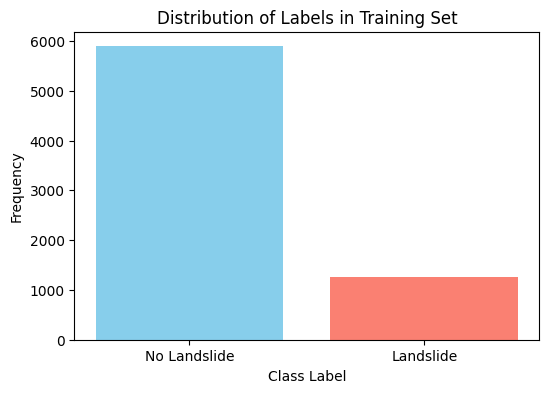

In [11]:
# Check distribution of labels
label_counts = train_df['label'].value_counts()

# Map the labels 0 and 1 to descriptive names
labels = ['No Landslide', 'Landslide']

# Plot distribution of labels
plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()

In [12]:
# # Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Visualize some of the Training Images

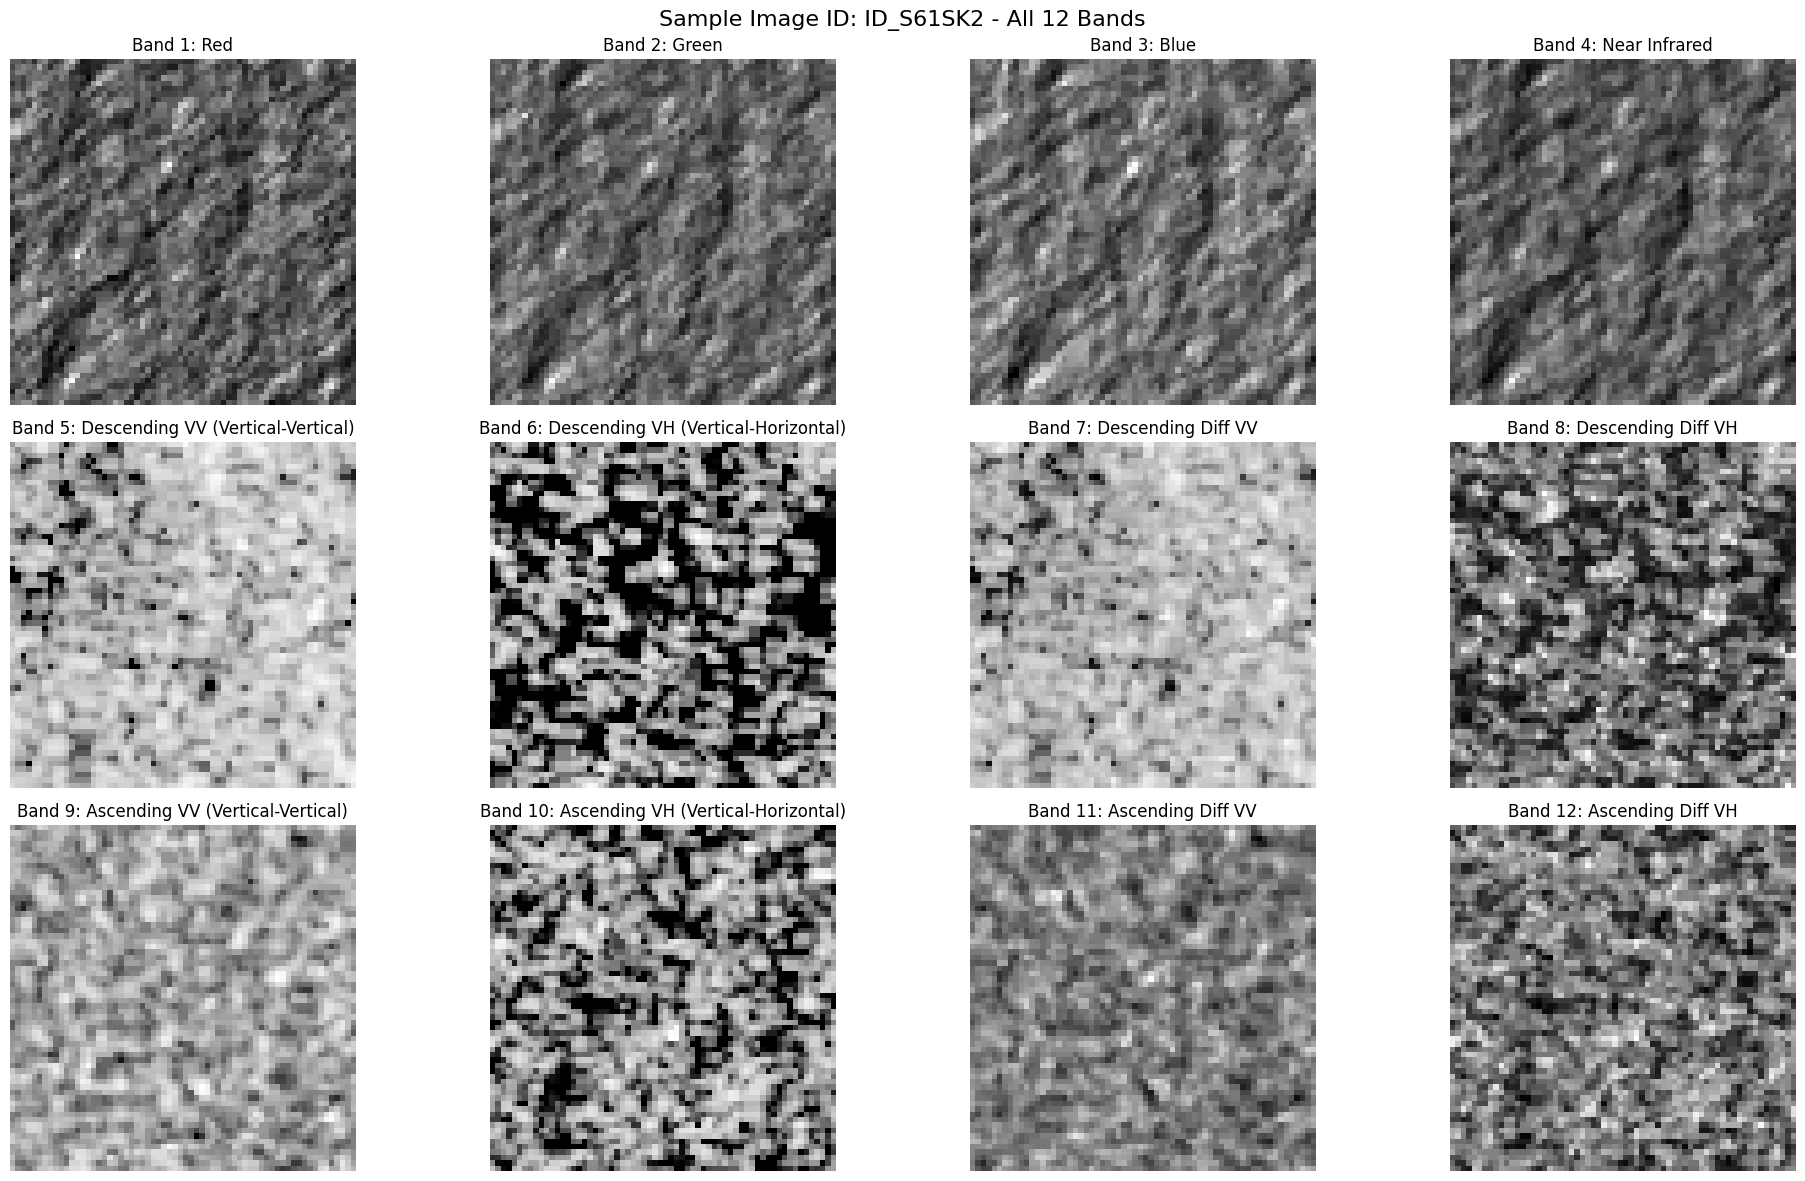

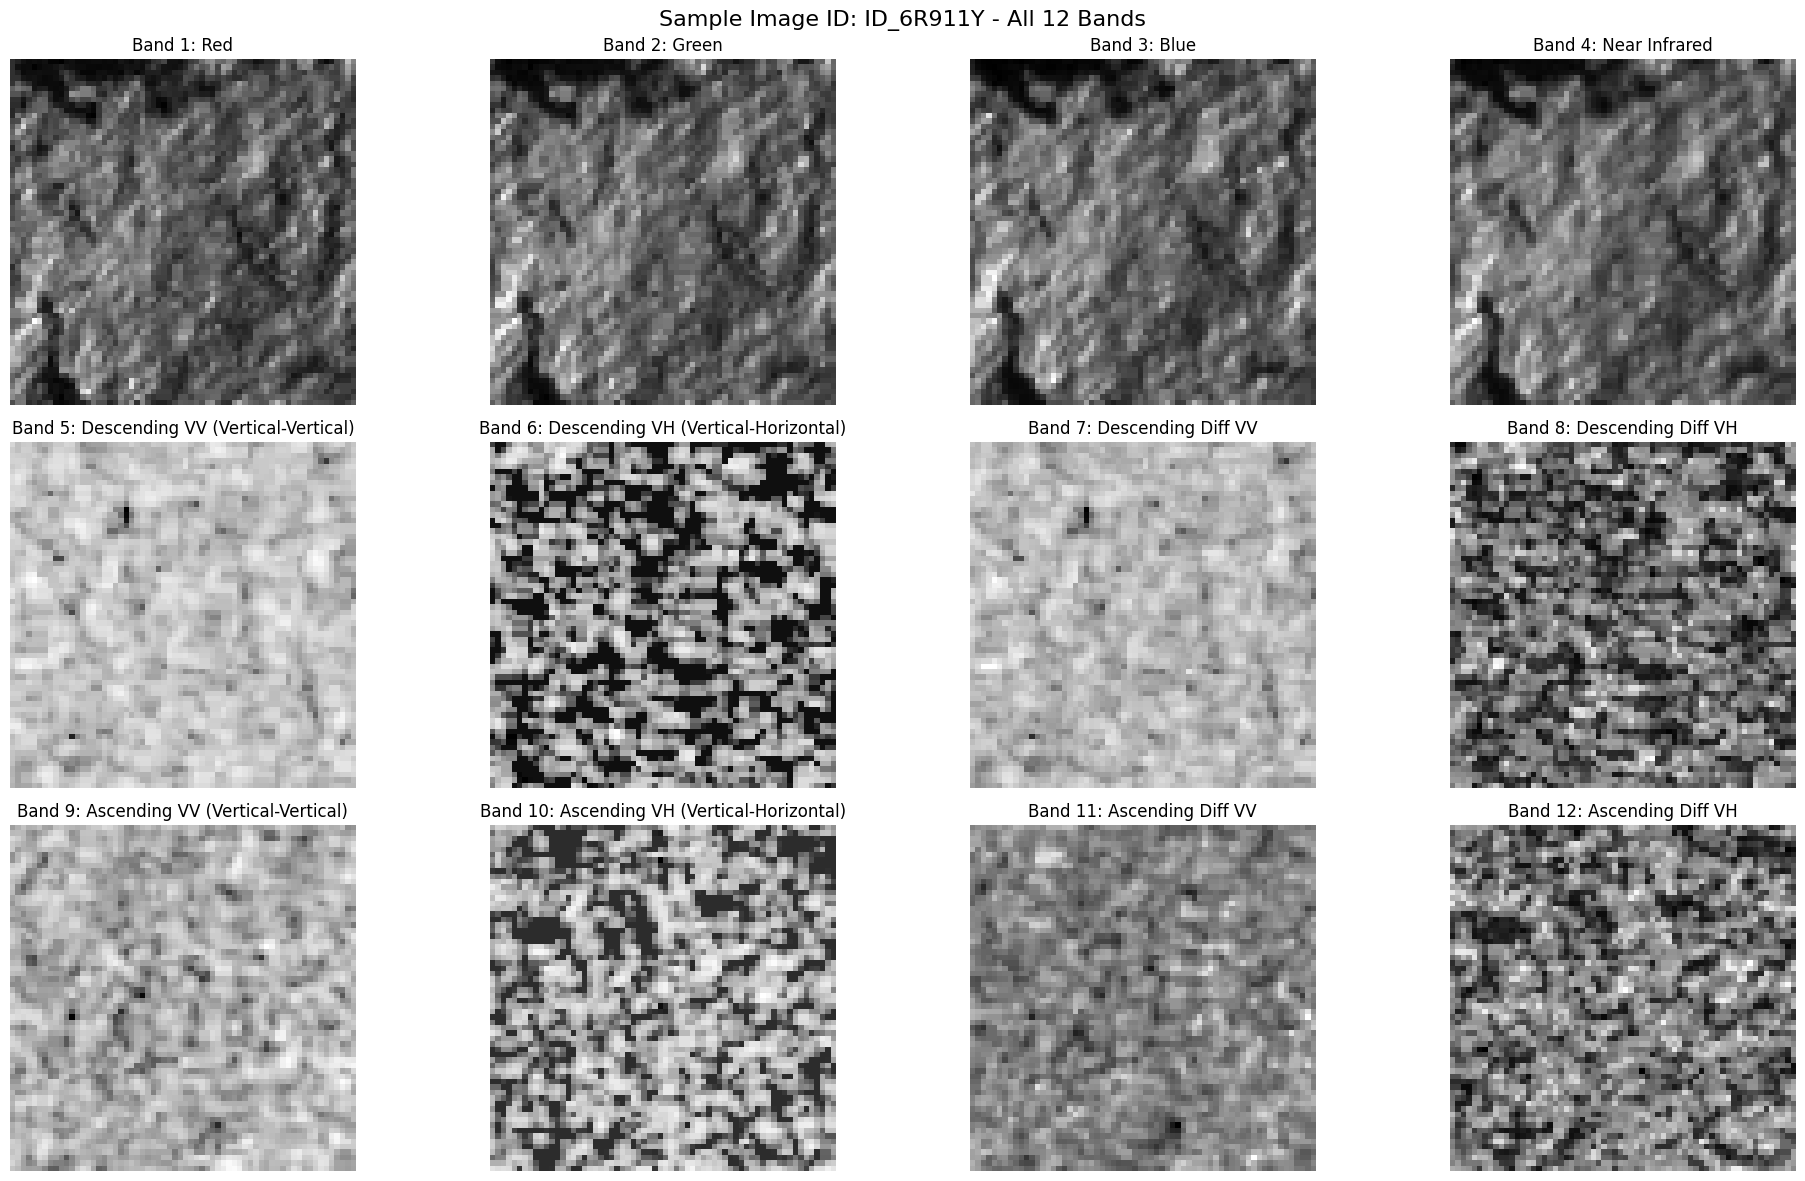

In [13]:
example_ids = train_df['id'].sample(2).values
for image_id in example_ids:
    img = np.load(train_data_path / f"{image_id}.npy")
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(f"Sample Image ID: {image_id} - All 12 Bands", fontsize=16)
    for band in range(12):
        row = band // 4
        col = band % 4
        axes[row, col].imshow(img[:, :, band], cmap='gray')
        axes[row, col].set_title(f"Band {band + 1}: {band_descriptions[band]}")
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()


# Split into training and validation sets

In [14]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
y_train = train_df['label'].values
y_val = val_df['label'].values

# Class Weights

In [15]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Create Data Generator Class

In [16]:
def augment_image(image):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
        return image

class LandslideDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_ids, labels, folder_path, batch_size=32, shuffle=True, augment=False):
        self.image_ids = image_ids
        self.labels = np.array(labels)
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.image_ids[i] for i in indexes]
        batch_labels = self.labels[indexes]

        batch_images = [self.load_and_normalize_npy_image(image_id) for image_id in batch_ids]
        batch_images = np.array(batch_images)

        if self.augment:
            batch_images = np.array([augment_image(tf.convert_to_tensor(img)).numpy() for img in batch_images])

        return batch_images, np.array(batch_labels)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_and_normalize_npy_image(self, image_id):
        path = os.path.join(self.folder_path, f"{image_id}.npy")
        img = np.load(path)
        img = (img - img.mean(axis=(0, 1))) / (img.std(axis=(0, 1)) + 1e-5)
        return img

# Create Generators

In [17]:
train_generator = LandslideDataGenerator(train_df['id'].values, y_train, train_data_path, batch_size=32, augment=True)
val_generator = LandslideDataGenerator(val_df['id'].values, y_val, train_data_path, batch_size=32, shuffle=False)

# F1 Score Callback

In [18]:
# F1Score Callback
from sklearn.metrics import precision_score, recall_score

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, save_path):
        self.val_generator = val_generator
        self.save_path = save_path
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for x_batch, y_batch in self.val_generator:
            preds = self.model.predict(x_batch)
            y_pred.extend((preds >= 0.5).astype(int).flatten())
            y_true.extend(y_batch)
            if len(y_true) >= len(self.val_generator.labels):
                break

        y_true, y_pred = np.array(y_true), np.array(y_pred)
        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        print(f"\nEpoch {epoch+1} - val_f1: {f1:.4f}, precision: {prec:.4f}, recall: {rec:.4f}")
        if f1 > self.best_f1:
            print(f"New best F1. Saving model to {self.save_path}")
            self.best_f1 = f1
            self.model.save(self.save_path)
        if logs:
            logs['val_f1'], logs['val_precision'], logs['val_recall'] = f1, prec, rec

# Build CNN Model

In [19]:
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(256, 256, 12)))

    # Tune number of conv layers 2-4
    for i in range(hp.Int('conv_layers', 2, 4)):
        filters = hp.Int(f'filters_{i}', 32, 128, step=32)
        model.add(layers.Conv2D(filters, 3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D())

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Keras Tuner

In [20]:
# Tuner Setup
cnn_save_path = data_path / "best_cnn_model_f1.keras"
f1_callback = F1ScoreCallback(val_generator, save_path=cnn_save_path)
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    directory= data_path /'kt_tuner_dir',
    project_name='landslide_cnn'
)

val_X = np.array([val_generator.load_and_normalize_npy_image(i) for i in val_df['id'].values])
val_y = val_df['label'].values

# Tuning
val_generator.labels = y_val
history = tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3), f1_callback]
)

# Load Best Model
best_cnn_model = tf.keras.models.load_model(cnn_save_path)

Reloading Tuner from /content/drive/MyDrive/LandslideDetection/kt_tuner_dir/landslide_cnn/tuner0.json


# Evaluate on Validation Set

In [21]:
val_preds_cnn = best_cnn_model.predict(val_generator)
val_preds_cnn_binary = (val_preds_cnn >= 0.5).astype(int)
print("CNN Val F1:", f1_score(val_y, val_preds_cnn_binary))
print(classification_report(val_y, val_preds_cnn_binary, target_names=['No Landslide', 'Landslide']))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step
CNN Val F1: 0.8293577981651377
              precision    recall  f1-score   support

No Landslide       0.98      0.94      0.96      1179
   Landslide       0.77      0.90      0.83       251

    accuracy                           0.93      1430
   macro avg       0.87      0.92      0.89      1430
weighted avg       0.94      0.93      0.94      1430



# Plot Confusion Matrix

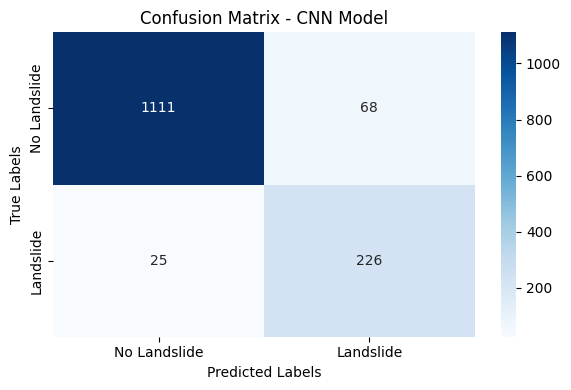

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(val_y, val_preds_cnn_binary)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Landslide', 'Landslide'], yticklabels=['No Landslide', 'Landslide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig(data_path / "confusion_matrix_cnn.png")
plt.show()

# Feature Engineering for Boosting models

In [23]:
def calculate_band_stats(img):
    # Calculate mean, std, min, max for each band
    mean = img.mean(axis=(0,1))
    std = img.std(axis=(0,1))
    mn = img.min(axis=(0,1))
    mx = img.max(axis=(0,1))
    return np.concatenate([mean, std, mn, mx])

def calculate_ndvi(img):
    # NDVI = (NIR - Red) / (NIR + Red), bands: NIR=3, Red=0
    nir = img[:,:,3]
    red = img[:,:,0]
    ndvi = (nir - red) / (nir + red + 1e-5)
    return np.array([ndvi.mean(), ndvi.std()])

def calculate_band_ratios(img):
    # Example band ratios: NIR/Red, NIR/Green, NIR/Blue
    nir = img[:,:,3]
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]
    ratios = []
    ratios.append(np.mean(nir/(red+1e-5)))
    ratios.append(np.mean(nir/(green+1e-5)))
    ratios.append(np.mean(nir/(blue+1e-5)))
    return np.array(ratios)

def prepare_features(df, folder_path):
    features = []
    for image_id in df['id'].values:
        img = np.load(folder_path / f"{image_id}.npy")
        stat_features = calculate_band_stats(img)
        ndvi_features = calculate_ndvi(img)
        ratio_features = calculate_band_ratios(img)
        feats = np.concatenate([stat_features, ndvi_features, ratio_features])
        features.append(feats)
    return np.array(features)

X_train_feat = prepare_features(train_df, train_data_path)
X_val_feat = prepare_features(val_df, train_data_path)
X_test_feat = prepare_features(test_df, test_data_path)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_val_scaled = scaler.transform(X_val_feat)
X_test_scaled = scaler.transform(X_test_feat)
joblib.dump(scaler, data_path / "scaler_boosting.pkl")

['/content/drive/MyDrive/LandslideDetection/scaler_boosting.pkl']

# Hyperparameter tuning for xgboost

In [24]:
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

xgb_gs = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
xgb_gs.fit(X_train_scaled, y_train)
print("Best XGBoost Params:", xgb_gs.best_params_)
y_pred_xgb = xgb_gs.predict(X_val_scaled)
print("XGBoost Val F1:", f1_score(y_val, y_pred_xgb))
print(classification_report(y_val, y_pred_xgb, target_names=['No Landslide', 'Landslide']))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:41:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
XGBoost Val F1: 0.8547717842323651
              precision    recall  f1-score   support

No Landslide       0.96      0.98      0.97      1179
   Landslide       0.89      0.82      0.85       251

    accuracy                           0.95      1430
   macro avg       0.93      0.90      0.91      1430
weighted avg       0.95      0.95      0.95      1430



# Confusion matrix for XGBoost

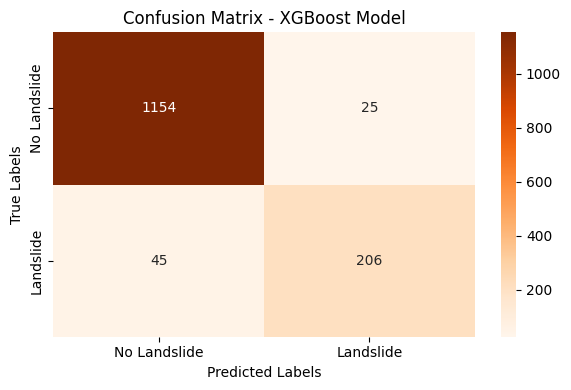

In [25]:
# Compute confusion matrix
cm_xgb = confusion_matrix(y_val, y_pred_xgb)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Landslide', 'Landslide'],
            yticklabels=['No Landslide', 'Landslide'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - XGBoost Model')
plt.tight_layout()
plt.savefig(data_path / "confusion_matrix_xgb.png")
plt.show()

# Hyperparameter tuning for LightGBM

In [26]:
lgbm_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

lgbm_gs = GridSearchCV(
    LGBMClassifier(),
    param_grid=lgbm_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
lgbm_gs.fit(X_train_scaled, y_train)
print("Best LightGBM Params:", lgbm_gs.best_params_)
y_pred_lgb = lgbm_gs.predict(X_val_scaled)
print("LightGBM Val F1:", f1_score(y_val, y_pred_lgb))
print(classification_report(y_val, y_pred_lgb, target_names=['No Landslide', 'Landslide']))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1004, number of negative: 4713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 5717, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175617 -> initscore=-1.546333
[LightGBM] [Info] Start training from score -1.546333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Confusion matrix for LightGBM

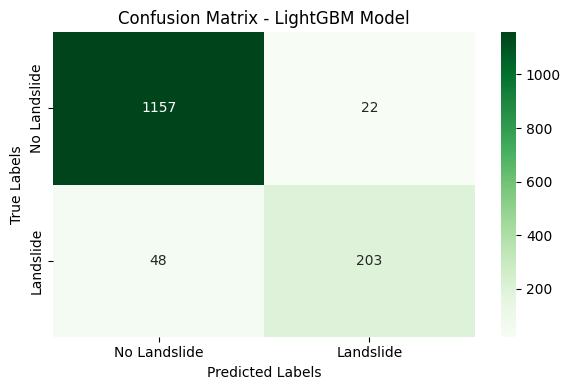

In [27]:
# Compute the confusion matrix
cm_lgb = confusion_matrix(y_val, y_pred_lgb)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Landslide', 'Landslide'],
            yticklabels=['No Landslide', 'Landslide'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LightGBM Model')
plt.tight_layout()
plt.savefig(data_path / "confusion_matrix_lgb.png")
plt.show()

# Stacking Ensemble with Logistic Regression

In [28]:
# Prepare CNN validation preds as feature
val_preds_cnn_proba = best_cnn_model.predict(val_generator).flatten()
train_generator_for_preds = LandslideDataGenerator(train_df['id'].values, y_train, train_data_path, augment=False, shuffle=False)
train_preds_cnn_proba = best_cnn_model.predict(train_generator_for_preds).flatten()

# Stack features: boosting features + CNN preds
X_train_stack = np.hstack([X_train_scaled, train_preds_cnn_proba.reshape(-1,1)])
X_val_stack = np.hstack([X_val_scaled, val_preds_cnn_proba.reshape(-1,1)])

estimators = [
    ('xgb', xgb_gs.best_estimator_),
    ('lgbm', lgbm_gs.best_estimator_)
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1,
    passthrough=True
)

stack_clf.fit(X_train_stack, y_train)
y_pred_stack = stack_clf.predict(X_val_stack)
print("Stacked Model Val F1:", f1_score(y_val, y_pred_stack))
print(classification_report(y_val, y_pred_stack, target_names=['No Landslide', 'Landslide']))

45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 57s 318ms/step
Stacked Model Val F1: 0.8589211618257261
              precision    recall  f1-score   support

No Landslide       0.96      0.98      0.97      1179
   Landslide       0.90      0.82      0.86       251

    accuracy                           0.95      1430
   macro avg       0.93      0.90      0.92      1430
weighted avg       0.95      0.95      0.95      1430



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Confusion matrix for Stacked Ensemble with LG

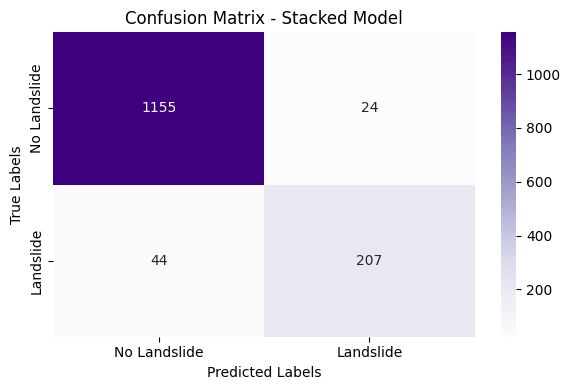

In [29]:
# Compute confusion matrix
cm_stack = confusion_matrix(y_val, y_pred_stack)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Purples',
            xticklabels=['No Landslide', 'Landslide'],
            yticklabels=['No Landslide', 'Landslide'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Stacked Model')
plt.tight_layout()
plt.savefig(data_path / "confusion_matrix_stack.png")
plt.show()

# Test Predictions

In [30]:
test_generator = LandslideDataGenerator(
    image_ids=test_df['id'].values,
    labels=[0]*len(test_df),
    folder_path=test_data_path,
    shuffle=False
)
test_preds_cnn = best_cnn_model.predict(test_generator)
test_pred_cnn_labels = (test_preds_cnn >= 0.5).astype(int).flatten()

X_test_stack = np.hstack([X_test_scaled, test_preds_cnn.flatten().reshape(-1,1)])
test_preds_stack = stack_clf.predict(X_test_stack)

# Save cnn predictions
pd.DataFrame({
    'id': test_df['id'],
    'label': test_pred_cnn_labels
}).to_csv(data_path / "cnn_submission.csv", index=False)

# Save stacked ensemble predictions
pd.DataFrame({
    'id': test_df['id'],
    'label': test_preds_stack
}).to_csv(data_path / "stacked_submission.csv", index=False)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Save the Models

In [31]:
# Define save paths and models
model_dir = data_path / "models"
model_dir.mkdir(parents=True, exist_ok=True)

models_to_save = {
    "best_cnn_model.keras": best_cnn_model,       # Keras model
    "best_xgb_model.pkl": xgb_gs.best_estimator_, # XGBoost model
    "best_lgbm_model.pkl": lgbm_gs.best_estimator_, # LightGBM model
    "stacked_model.pkl": stack_clf                # Stacking model
}

for filename, model in models_to_save.items():
    model_path = model_dir / filename
    if filename.endswith(".keras"):
        model.save(model_path)
    else:
        joblib.dump(model, model_path)